In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Metric
from tensorflow.keras import regularizers
from tensorflow.keras import models
import numpy as np
import logging
import matplotlib.pyplot as plt
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(7)
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Load training and test datasets.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Divida os dados em conjuntos de treinamento e teste
validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Standardize the data.
mean = np.mean(train_images)
stddev = np.std(train_images)
train_images = (train_images - mean) / stddev
test_images = (test_images - mean) / stddev
validation_images = (validation_images - mean) / stddev

# One-hot encode labels.
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)
validation_labels = to_categorical(validation_labels, num_classes=10)

In [ ]:
# Object used to initialize weights.
initializer = keras.initializers.RandomUniform(
    minval=-0.1, maxval=0.1)

# Create a Sequential model.
# 784 inputs.
# Two Dense (fully connected) layers with 25 and 10 neurons.
# tanh as activation function for hidden layer.
# Logistic (sigmoid) as activation function for output layer.
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(50, activation='relu',
                       kernel_initializer=initializer,
                       bias_initializer='zeros'),
    keras.layers.Dense(10, activation='softmax',
                       kernel_initializer=initializer,
                       bias_initializer='zeros')])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
class L2ComplexityMetric(Metric):
    def __init__(self, name='l2_complexity', **kwargs):
        super(L2ComplexityMetric, self).__init__(name=name, **kwargs)
        self.l2_loss = self.add_weight(name='l2_loss', initializer='zeros')
        self.model = None

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.model is not None:
            # Calcula a perda de complexidade L2 (regularização L2)
            l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])
            self.l2_loss.assign_add(l2_loss)

    def result(self):
        return self.l2_loss

    def reset_state(self):  # Altere o nome deste método para reset_state
        # Zera as variáveis acumuladas no início de cada época ou avaliação
        self.l2_loss.assign(0.0)

In [ ]:
class CustomLoss(losses.Loss):
    def __init__(self, weights=(0.0, 0.0), name="custom_loss"):
        super().__init__(name=name)
        self.weights = weights

    def call(self, y_true, y_pred):
        # Calcula a perda de entropia cruzada (erro).
        cross_entropy_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Calcula a perda de complexidade L2 (regularização).
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])

        # Combine as duas perdas.
        return self.weights[0]* cross_entropy_loss + self.weights[1] * l2_loss

    def get_config(self):
        config = super(CustomLoss, self).get_config()
        config.update({"weigths": self.weights})
        return config

In [ ]:
# Treinar modelos com diferentes funções de loss
N_weights = 50
pareto_metrics_wheights = []
pareto_metrics_wheights_teste = []
epochs_loss_train_wheights = []
epochs_loss_val_wheights = []
pareto_metrics_wheights_3D = []
pareto_metrics_wheights_teste_3D = []

# Criar uma instância da métrica personalizada
l2_metric = L2ComplexityMetric()
l2_metric.model = model  # Adicione esta linha para passar a referência do modelo para a métrica

opt = keras.optimizers.Adam()

In [ ]:
for i in range(N_weights):

  weight1 = np.linspace(0, 1, N_weights, endpoint=True)[i]
  weight2 = 1-weight1
  weights=(weight1, weight2)
  print('Model', i+1, ': weight1 =', weight1, 'and weight2 =', weight2)

  #Instancie a classe de perda personalizada.
  custom_loss = CustomLoss(weights)
  custom_loss.model = model  # Associando o modelo à função de perda.

  model.compile(loss=custom_loss, optimizer = opt, metrics=['categorical_crossentropy', l2_metric])
  training_history = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=10, batch_size=32, verbose=0, shuffle=True)

  # Calculate the error and norm L2 on the test set
  metrics = model.evaluate(validation_images, validation_labels)
  loss_val = metrics[0]
  error_value = metrics[1]
  l2_complexity = metrics[2]

  pareto_metrics_wheights.append((l2_complexity, error_value))
  pareto_metrics_wheights_3D.append((l2_complexity, error_value, loss_val, weight1, weight2))
  pareto_metrics_wheights_3D.sort()

  # Calculate the error and norm L2 on the test set
  metrics = model.evaluate(test_images, test_labels)
  loss_test = metrics[0]
  error_value_test = metrics[1]
  l2_complexity_test = metrics[2]

  pareto_metrics_wheights_teste.append((l2_complexity_test, error_value_test))
  pareto_metrics_wheights_teste_3D.append((l2_complexity_test, error_value_test, loss_test, weight1, weight2))
  pareto_metrics_wheights_teste_3D.sort()

  # Obtenha a função de perda nos dados de treinamento e validação
  train_loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']

  # Crie um vetor de épocas para os eixos x
  epochs = np.arange(1, len(train_loss) + 1)

  epochs_loss_train_wheights.append((epochs, train_loss))
  epochs_loss_val_wheights.append((epochs, val_loss))

Model 1 : weight1 = 0.0 and weight2 = 1.0
157/157 [==============================] - 0s 2ms/step - loss: 2.1794e-07 - categorical_crossentropy: 2.3026 - l2_complexity: 3.4216e-05
Model 2 : weight1 = 0.02040816326530612 and weight2 = 0.9795918367346939
157/157 [==============================] - 0s 2ms/step - loss: 0.0470 - categorical_crossentropy: 2.3026 - l2_complexity: 0.0021
Model 3 : weight1 = 0.04081632653061224 and weight2 = 0.9591836734693877
157/157 [==============================] - 0s 2ms/step - loss: 0.0940 - categorical_crossentropy: 2.3026 - l2_complexity: 0.0037
Model 4 : weight1 = 0.061224489795918366 and weight2 = 0.9387755102040817
157/157 [==============================] - 1s 3ms/step - loss: 0.1410 - categorical_crossentropy: 2.3026 - l2_complexity: 0.0045
Model 5 : weight1 = 0.08163265306122448 and weight2 = 0.9183673469387755
157/157 [==============================] - 0s 2ms/step - loss: 0.1880 - categorical_crossentropy: 2.3026 - l2_complexity: 0.0053
Model 6 : we

In [ ]:
class ChebyshevLoss(losses.Loss):
    def __init__(self, beta=0.01, ideal_loss_point=(0.0, 0.0), weights=(1.0, 1.0), name="chebyshev_loss"):
        super().__init__(name=name)
        self.beta = beta
        self.ideal_loss_point = ideal_loss_point
        self.weights = weights

    def call(self, y_true, y_pred):
        # Calcula a perda de entropia cruzada (erro)
        error_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Calcula a perda de complexidade L2 (regularização L2)
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])

        # A Escalarização Chebyshev envolve a maximização do mínimo dos pesos ponderados
        # Chebyshev loss é essencialmente a maior diferença ponderada de cada objetivo para os pontos ideais
        weighted_error_diff = self.weights[0] * (error_loss - self.ideal_loss_point[0])
        weighted_l2_diff = self.weights[1] * (l2_loss - self.ideal_loss_point[1])

        # Combinando os componentes da perda seguindo o critério de Chebyshev
        chebyshev_loss = tf.maximum(weighted_error_diff, weighted_l2_diff)
        return chebyshev_loss

    def get_config(self):
        config = super(ChebyshevLoss, self).get_config()
        config.update({
            "beta": self.beta,
            "ideal_loss_point": self.ideal_loss_point,
            "weights": self.weights
        })
        return config


In [ ]:
# Treinar modelos com diferentes funções de loss
N_cheb = 50
pareto_metrics_cheb = []
pareto_metrics_cheb_test = []
epochs_loss_train_cheb = []
epochs_loss_val_cheb = []
pareto_metrics_cheb_3D = []
pareto_metrics_cheb_tests_3D = []

# Instancie a classe de perda personalizada Chebyshev
beta = 0.01
ideal_loss_point = (0.0, 0.0)

In [ ]:
for i in range(N_cheb):

  weight1 = np.linspace(0, 1, N_cheb, endpoint=True)[i]
  weight2 = 1-weight1
  weights=(weight1, weight2)
  print('Model', i+1, ': weight1 =', weight1, 'and weight2 =', weight2)

  custom_loss_cheb = ChebyshevLoss(beta, ideal_loss_point, weights)
  custom_loss_cheb.model = model

  model.compile(loss=custom_loss_cheb, optimizer=opt, metrics=['categorical_crossentropy', l2_metric])
  training_history = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=10, batch_size=32, verbose=0, shuffle=True)

  # Calculate the error and norm L2 on the test set
  metrics = model.evaluate(validation_images, validation_labels)
  loss_val = metrics[0]
  error_value = metrics[1]
  l2_complexity = metrics[2]

  pareto_metrics_cheb.append((l2_complexity, error_value))
  pareto_metrics_cheb_3D.append((l2_complexity,error_value, loss_val, weight1, weight2))
  pareto_metrics_cheb_3D.sort()

  # Calculate the error and norm L2 on the test set
  metrics = model.evaluate(test_images, test_labels)
  loss_test = metrics[0]
  error_value_test = metrics[1]
  l2_complexity_test = metrics[2]

  pareto_metrics_cheb_test.append((l2_complexity_test, error_value_test))
  pareto_metrics_cheb_tests_3D.append((l2_complexity_test,error_value_test, loss_test, weight1, weight2))
  pareto_metrics_cheb_tests_3D.sort()

  # Obtenha a função de perda nos dados de treinamento e validação
  train_loss_cheb = training_history.history['loss']
  val_loss_cheb = training_history.history['val_loss']

  # Crie um vetor de épocas para os eixos x
  epochs = np.arange(1, len(train_loss_cheb) + 1)

  epochs_loss_train_cheb.append((epochs, train_loss_cheb))
  epochs_loss_val_cheb.append((epochs, val_loss_cheb))

Model 1 : weight1 = 0.0 and weight2 = 1.0
157/157 [==============================] - 0s 2ms/step - loss: 5.3946e-07 - categorical_crossentropy: 2.3026 - l2_complexity: 8.4695e-05
Model 2 : weight1 = 0.02040816326530612 and weight2 = 0.9795918367346939
157/157 [==============================] - 0s 2ms/step - loss: 0.0458 - categorical_crossentropy: 2.2377 - l2_complexity: 7.0869
Model 3 : weight1 = 0.04081632653061224 and weight2 = 0.9591836734693877
157/157 [==============================] - 1s 3ms/step - loss: 0.0892 - categorical_crossentropy: 2.1777 - l2_complexity: 13.9947
Model 4 : weight1 = 0.061224489795918366 and weight2 = 0.9387755102040817
157/157 [==============================] - 0s 2ms/step - loss: 0.1305 - categorical_crossentropy: 2.1274 - l2_complexity: 20.4643
Model 5 : weight1 = 0.08163265306122448 and weight2 = 0.9183673469387755
157/157 [==============================] - 0s 2ms/step - loss: 0.1696 - categorical_crossentropy: 2.0726 - l2_complexity: 27.0661
Model 6 :

In [ ]:
def print_pareto_metrics(data, dataset_type):
    print(f"Dados de {dataset_type}:")
    for i, (norm, error) in enumerate(data, start=1):
        print(f"Modelo {i} - {dataset_type}: Norma L2 = {norm}, Erro = {error}")
    print()

print_pareto_metrics(pareto_metrics_wheights, "Validação")
print_pareto_metrics(pareto_metrics_wheights_teste, "Teste")

Dados de Validação:
Modelo 1 - Validação: Norma L2 = 3.4216322092106566e-05, Erro = 2.3025825023651123
Modelo 2 - Validação: Norma L2 = 0.0021438063122332096, Erro = 2.3025808334350586
Modelo 3 - Validação: Norma L2 = 0.0036569770891219378, Erro = 2.302579641342163
Modelo 4 - Validação: Norma L2 = 0.004521658178418875, Erro = 2.3025691509246826
Modelo 5 - Validação: Norma L2 = 0.005298587493598461, Erro = 2.3025712966918945
Modelo 6 - Validação: Norma L2 = 0.006307834759354591, Erro = 2.3025736808776855
Modelo 7 - Validação: Norma L2 = 0.007396497298032045, Erro = 2.302574634552002
Modelo 8 - Validação: Norma L2 = 0.009546562097966671, Erro = 2.3025739192962646
Modelo 9 - Validação: Norma L2 = 0.011436071246862411, Erro = 2.3025729656219482
Modelo 10 - Validação: Norma L2 = 0.013411366380751133, Erro = 2.30257248878479
Modelo 11 - Validação: Norma L2 = 0.016065215691924095, Erro = 2.302574634552002
Modelo 12 - Validação: Norma L2 = 0.01905110664665699, Erro = 2.30257511138916
Modelo 13

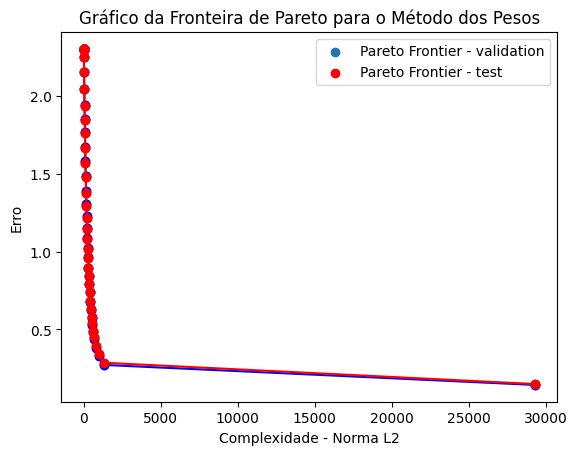

In [ ]:
# Ordena os pontos da fronteira de Pareto com base na norma L2
pareto_metrics_wheights_sorted = sorted(pareto_metrics_wheights, key=lambda x: x[1])

# Extrai os erros e as normas ordenadas
norms_sorted, errors_sorted = zip(*pareto_metrics_wheights_sorted)

# Cria um gráfico de dispersão
plt.scatter(norms_sorted, errors_sorted, label='Pareto Frontier - validation')

# Adiciona uma linha ligando os pontos ordenados
plt.plot(norms_sorted, errors_sorted, linestyle='-', marker='o', color='b')

# Ordena os pontos da segunda linha com base na norma L2
pareto_metrics_second_line_sorted = sorted(pareto_metrics_wheights_teste, key=lambda x: x[1])

# Extrai os erros e as normas ordenadas da segunda linha
norms_second_line_sorted, errors_second_line_sorted = zip(*pareto_metrics_second_line_sorted)

# Cria um gráfico de dispersão para a segunda linha
plt.scatter(norms_second_line_sorted, errors_second_line_sorted, label='Pareto Frontier - test', color='red')

# Adiciona uma linha ligando os pontos ordenados da segunda linha
plt.plot(norms_second_line_sorted, errors_second_line_sorted, linestyle='-', marker='o', color='red')

# Adiciona rótulos aos eixos
plt.xlabel('Complexidade - Norma L2')
plt.ylabel('Erro')

# Adiciona um título ao gráfico
plt.title('Gráfico da Fronteira de Pareto para o Método dos Pesos')

# Adiciona uma legenda ao gráfico
plt.legend()

# Exibe o gráfico
plt.show()

In [ ]:
# Dados de treino
for i, (epochs, train_loss) in enumerate(epochs_loss_train_wheights, start=1):
    print(f"Rede Neural {i} - Dados de Treino:")
    for epoch, loss in zip(epochs, train_loss):
        print(f"Época {epoch}: Loss = {loss}")
    print("\n")

# Dados de validação
for i, (epochs, val_loss) in enumerate(epochs_loss_val_wheights, start=1):
    print(f"Rede Neural {i} - Dados de Validação:")
    for epoch, loss in zip(epochs, val_loss):
        print(f"Época {epoch}: Loss = {loss}")
    print("\n")

Rede Neural 1 - Dados de Treino:
Época 1: Loss = 0.9997361898422241
Época 2: Loss = 2.1198430033564364e-07
Época 3: Loss = 2.827388243531459e-07
Época 4: Loss = 2.899092237385048e-07
Época 5: Loss = 2.8981344257772435e-07
Época 6: Loss = 2.8571622578965616e-07
Época 7: Loss = 2.8395129447744694e-07
Época 8: Loss = 2.854804108665121e-07
Época 9: Loss = 2.8541427354866755e-07
Época 10: Loss = 2.8541549568217306e-07


Rede Neural 2 - Dados de Treino:
Época 1: Loss = 0.04735802859067917
Época 2: Loss = 0.046994853764772415
Época 3: Loss = 0.04700575768947601
Época 4: Loss = 0.047007497400045395
Época 5: Loss = 0.04700756072998047
Época 6: Loss = 0.04700765386223793
Época 7: Loss = 0.04700746387243271
Época 8: Loss = 0.04700740426778793
Época 9: Loss = 0.04700765013694763
Época 10: Loss = 0.04700756072998047


Rede Neural 3 - Dados de Treino:
Época 1: Loss = 0.0940018892288208
Época 2: Loss = 0.09400130063295364
Época 3: Loss = 0.0940011590719223
Época 4: Loss = 0.09400118142366409
Época 5:

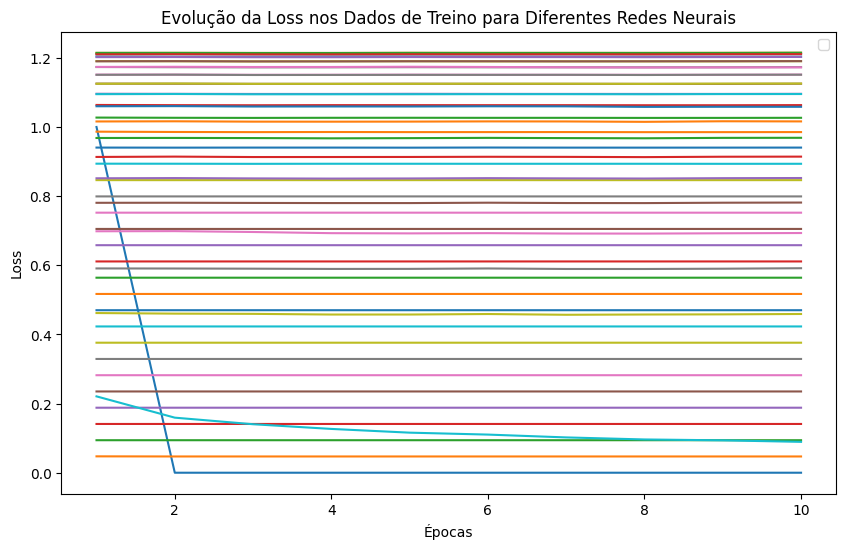

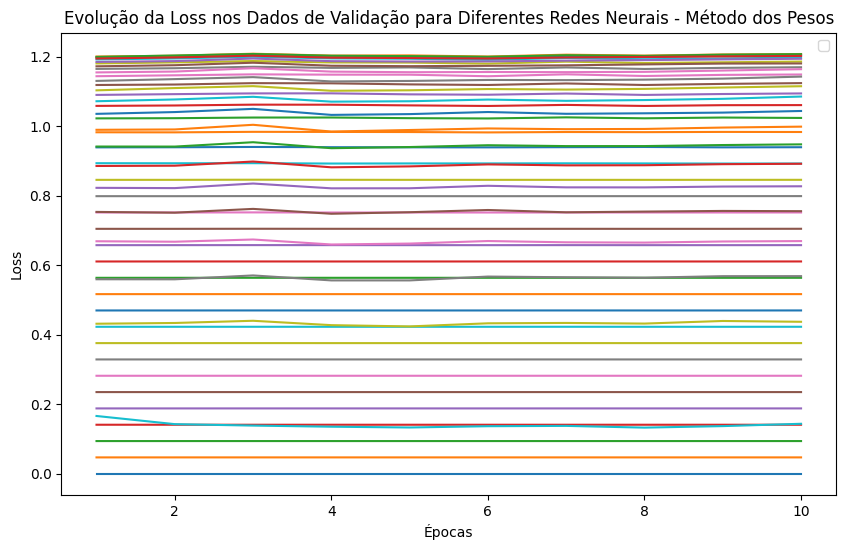

In [ ]:
# Crie um gráfico para os dados de treino
plt.figure(figsize=(10, 6))

for i, (epochs, train_loss) in enumerate(epochs_loss_train_wheights, start=1):
    # Adicione uma linha para cada rede neural
    plt.plot(epochs, train_loss)

# Adicione rótulos aos eixos
plt.xlabel('Épocas')
plt.ylabel('Loss')

# Adicione um título ao gráfico
plt.title('Evolução da Loss nos Dados de Treino para Diferentes Redes Neurais')

# Adicione uma legenda ao gráfico
plt.legend()

# Exiba o gráfico
plt.show()

# Crie um gráfico para os dados de validação
plt.figure(figsize=(10, 6))

for i, (epochs, val_loss) in enumerate(epochs_loss_val_wheights, start=1):
    # Adicione uma linha para cada rede neural
    plt.plot(epochs, val_loss)

# Adicione rótulos aos eixos
plt.xlabel('Épocas')
plt.ylabel('Loss')

# Adicione um título ao gráfico
plt.title('Evolução da Loss nos Dados de Validação para Diferentes Redes Neurais - Método dos Pesos')

# Adicione uma legenda ao gráfico
plt.legend()

# Exiba o gráfico
plt.show()

In [ ]:
pareto_metrics_wheights_teste_3D_nor = []
complexidade_mínimo = 1e12
complexidade_máximo = 0
erro_mínimo = 1e12
erro_máximo = 0

# Imprima os dados
for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_wheights_teste_3D, start=1):
    print(f'Rede Neuronal {i}: Complexidade={complexidade}, Erro={erro}, Loss={loss}, wheight1={wheight1}, wheight2={wheight2}')
    complexidade_mínimo = min(complexidade_mínimo, complexidade)
    complexidade_máximo = max(complexidade_máximo, complexidade)
    erro_mínimo = min(erro_mínimo, erro)
    erro_máximo = max(erro_máximo, erro)

for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_wheights_teste_3D, start=1):
    erro_nor =  (erro - erro_mínimo) / (erro_máximo - erro_mínimo)
    complexidade_nor = (complexidade - complexidade_mínimo) / (complexidade_máximo - complexidade_mínimo)
    loss_nor = erro_nor * wheight1 + complexidade_nor * wheight2
    pareto_metrics_wheights_teste_3D_nor.append((complexidade_nor, erro_nor, loss_nor, wheight1, wheight2))

print()
print("Dados Normalizados:")
for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_wheights_teste_3D_nor, start=1):
    print(f'Rede Neuronal {i}: Complexidade={complexidade}, Erro={erro}, Loss={loss}, wheight1={wheight1}, wheight2={wheight2}')

Rede Neuronal 1: Complexidade=3.4216322092106566e-05, Erro=2.3025825023651123, Loss=2.179383784550737e-07, wheight1=0.0, wheight2=1.0
Rede Neuronal 2: Complexidade=0.0021438063122332096, Erro=2.3025782108306885, Loss=0.04700475558638573, wheight1=0.02040816326530612, wheight2=0.9795918367346939
Rede Neuronal 3: Complexidade=0.0036569770891219378, Erro=2.3025760650634766, Loss=0.0940050482749939, wheight1=0.04081632653061224, wheight2=0.9591836734693877
Rede Neuronal 4: Complexidade=0.004521658178418875, Erro=2.302565813064575, Loss=0.14100049436092377, wheight1=0.061224489795918366, wheight2=0.9387755102040817
Rede Neuronal 5: Complexidade=0.005298587493598461, Erro=2.3025565147399902, Loss=0.18799474835395813, wheight1=0.08163265306122448, wheight2=0.9183673469387755
Rede Neuronal 6: Complexidade=0.006307834759354591, Erro=2.302539587020874, Loss=0.23498918116092682, wheight1=0.1020408163265306, wheight2=0.8979591836734694
Rede Neuronal 7: Complexidade=0.007396497298032045, Erro=2.302

<ipython-input-15-721c4b350808>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[i], y[i], z[i], c=color, marker=marker, label=label)


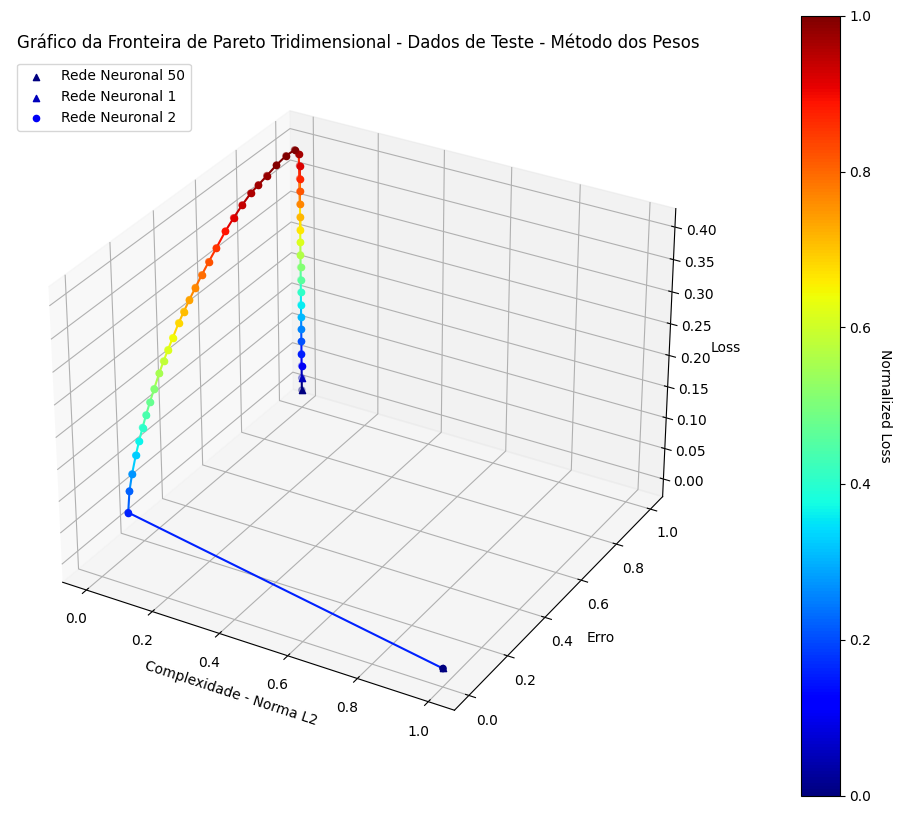

In [ ]:
# Extraia as variáveis
x, y, z, w1, w2 = zip(*pareto_metrics_wheights_teste_3D_nor)

# Crie a figura e o eixo 3D com tamanho ajustado
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Converta z para um array NumPy e normalize os valores para obter cores entre 0 e 1
normalized_z = (np.array(z) - min(z)) / (max(z) - min(z))

# Encontre os índices dos 3 pontos com menor valor de z
indice_3_menores_z = np.argpartition(z, 3)[:3]

for i in range(len(x)):
    marker = 'o' if not np.any(i == indice_3_menores_z) else '^'
    color = plt.cm.jet(normalized_z[i])
    label = None if not np.any(i == indice_3_menores_z) else f'Rede Neuronal {i + 1}'

    # Plote os pontos individuais
    ax.scatter(x[i], y[i], z[i], c=color, marker=marker, label=label)

# Plote a linha conectando os pontos e variação de cor
for i in range(len(x) - 1):
    color = plt.cm.jet(normalized_z[i])
    ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], [z[i], z[i + 1]], color=color)

# Adicione a barra de cores
cbar = fig.colorbar(ax.scatter(x, y, z, c=normalized_z, cmap='jet', marker='o'), ax=ax, pad=0.1)
cbar.set_label('Normalized Loss', rotation=270, labelpad=15)

# Rotule os eixos
ax.set_xlabel('Complexidade - Norma L2')
ax.set_ylabel('Erro')
ax.set_zlabel('Loss')

# Ajuste a posição da legenda e aumente o espaço entre os subplots
fig.subplots_adjust(bottom=0.1)

# Adicione um título ao gráfico
ax.set_title('Gráfico da Fronteira de Pareto Tridimensional - Dados de Teste - Método dos Pesos')

# Adicione a legenda
ax.legend([f'Rede Neuronal {i + 1}' for i in indice_3_menores_z], loc='upper left')

# Mostre o gráfico
plt.show()

In [ ]:
pareto_metrics_wheights_3D_nor = []
complexidade_mínimo = 1e12
complexidade_máximo = 0
erro_mínimo = 1e12
erro_máximo = 0

# Imprima os dados
for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_wheights_3D, start=1):
    print(f'Rede Neuronal {i}: Complexidade={complexidade}, Erro={erro}, Loss={loss}, wheight1={wheight1}, wheight2={wheight2}')
    complexidade_mínimo = min(complexidade_mínimo, complexidade)
    complexidade_máximo = max(complexidade_máximo, complexidade)
    erro_mínimo = min(erro_mínimo, erro)
    erro_máximo = max(erro_máximo, erro)

for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_wheights_3D, start=1):
    erro_nor =  (erro - erro_mínimo) / (erro_máximo - erro_mínimo)
    complexidade_nor = (complexidade - complexidade_mínimo) / (complexidade_máximo - complexidade_mínimo)
    loss_nor = erro_nor * wheight1 + complexidade_nor * wheight2
    pareto_metrics_wheights_3D_nor.append((complexidade_nor, erro_nor, loss_nor, wheight1, wheight2))

print()
print("Dados Normalizados:")
for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_wheights_3D_nor, start=1):
    print(f'Rede Neuronal {i}: Complexidade={complexidade}, Erro={erro}, Loss={loss}, wheight1={wheight1}, wheight2={wheight2}')

Rede Neuronal 1: Complexidade=3.4216322092106566e-05, Erro=2.3025825023651123, Loss=2.179383784550737e-07, wheight1=0.0, wheight2=1.0
Rede Neuronal 2: Complexidade=0.0021438063122332096, Erro=2.3025808334350586, Loss=0.0470048263669014, wheight1=0.02040816326530612, wheight2=0.9795918367346939
Rede Neuronal 3: Complexidade=0.0036569770891219378, Erro=2.302579641342163, Loss=0.09400516748428345, wheight1=0.04081632653061224, wheight2=0.9591836734693877
Rede Neuronal 4: Complexidade=0.004521658178418875, Erro=2.3025691509246826, Loss=0.1410006433725357, wheight1=0.061224489795918366, wheight2=0.9387755102040817
Rede Neuronal 5: Complexidade=0.005298587493598461, Erro=2.3025712966918945, Loss=0.1879960000514984, wheight1=0.08163265306122448, wheight2=0.9183673469387755
Rede Neuronal 6: Complexidade=0.006307834759354591, Erro=2.3025736808776855, Loss=0.23499257862567902, wheight1=0.1020408163265306, wheight2=0.8979591836734694
Rede Neuronal 7: Complexidade=0.007396497298032045, Erro=2.3025

<ipython-input-17-284fae31a1aa>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[i], y[i], z[i], c=color, marker=marker, label=label)


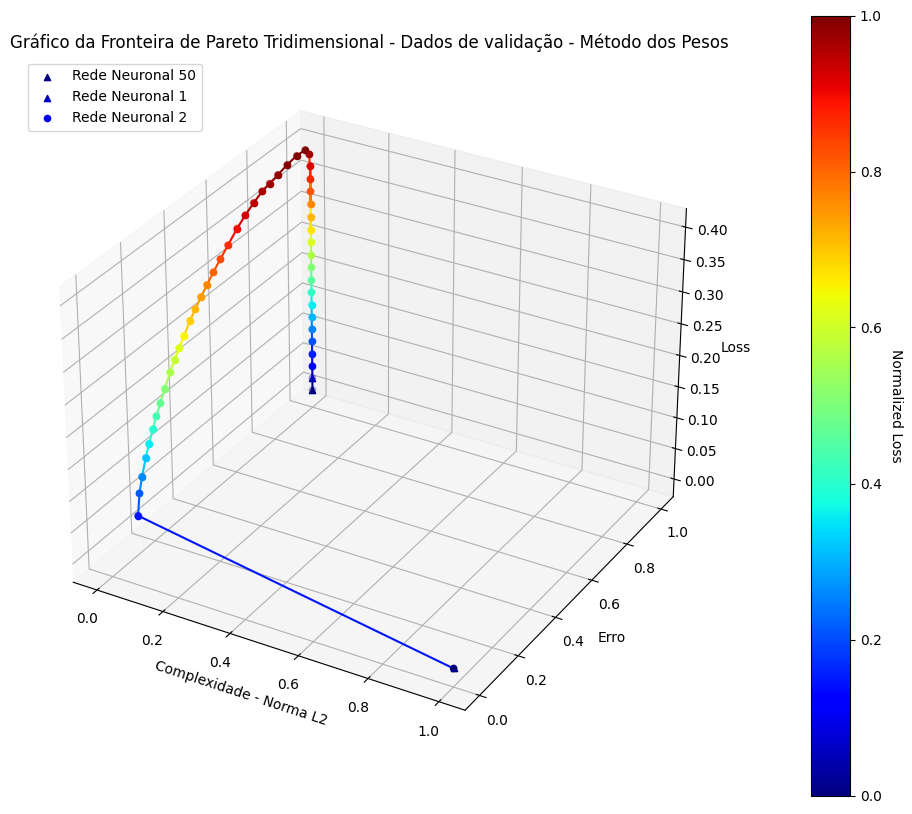

In [ ]:
# Extraia as variáveis
x, y, z, w1, w2 = zip(*pareto_metrics_wheights_3D_nor)

# Crie a figura e o eixo 3D com tamanho ajustado
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Converta z para um array NumPy e normalize os valores para obter cores entre 0 e 1
normalized_z = (np.array(z) - min(z)) / (max(z) - min(z))

# Encontre os índices dos 3 pontos com menor valor de z
indice_3_menores_z = np.argpartition(z, 3)[:3]

for i in range(len(x)):
    marker = 'o' if not np.any(i == indice_3_menores_z) else '^'
    color = plt.cm.jet(normalized_z[i])
    label = None if not np.any(i == indice_3_menores_z) else f'Rede Neuronal {i + 1}'

    # Plote os pontos individuais
    ax.scatter(x[i], y[i], z[i], c=color, marker=marker, label=label)

# Plote a linha conectando os pontos e variação de cor
for i in range(len(x) - 1):
    color = plt.cm.jet(normalized_z[i])
    ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], [z[i], z[i + 1]], color=color)

# Adicione a barra de cores
cbar = fig.colorbar(ax.scatter(x, y, z, c=normalized_z, cmap='jet', marker='o'), ax=ax, pad=0.1)
cbar.set_label('Normalized Loss', rotation=270, labelpad=15)

# Rotule os eixos
ax.set_xlabel('Complexidade - Norma L2')
ax.set_ylabel('Erro')
ax.set_zlabel('Loss')

# Ajuste a posição da legenda e aumente o espaço entre os subplots
fig.subplots_adjust(bottom=0.1)

# Adicione um título ao gráfico
ax.set_title('Gráfico da Fronteira de Pareto Tridimensional - Dados de validação - Método dos Pesos')

# Adicione a legenda
ax.legend([f'Rede Neuronal {i + 1}' for i in indice_3_menores_z], loc='upper left')

# Mostre o gráfico
plt.show()

In [ ]:
def print_pareto_metrics(data, dataset_type):
    print(f"Dados de {dataset_type}:")
    for i, (norm, error) in enumerate(data, start=1):
        print(f"Modelo {i} - {dataset_type}: Norma L2 = {norm}, Erro = {error}")
    print()

print_pareto_metrics(pareto_metrics_cheb, "Validação")
print_pareto_metrics(pareto_metrics_cheb_test, "Teste")

Dados de Validação:
Modelo 1 - Validação: Norma L2 = 8.469532622257248e-05, Erro = 2.3025825023651123
Modelo 2 - Validação: Norma L2 = 7.086946487426758, Erro = 2.2383933067321777
Modelo 3 - Validação: Norma L2 = 13.994668006896973, Erro = 2.1780905723571777
Modelo 4 - Validação: Norma L2 = 20.464340209960938, Erro = 2.1286513805389404
Modelo 5 - Validação: Norma L2 = 27.066144943237305, Erro = 2.0744268894195557
Modelo 6 - Validação: Norma L2 = 33.70469665527344, Erro = 2.0240132808685303
Modelo 7 - Validação: Norma L2 = 40.06326675415039, Erro = 1.979407787322998
Modelo 8 - Validação: Norma L2 = 45.900699615478516, Erro = 1.9375556707382202
Modelo 9 - Validação: Norma L2 = 52.18644714355469, Erro = 1.896301031112671
Modelo 10 - Validação: Norma L2 = 57.4262809753418, Erro = 1.8623892068862915
Modelo 11 - Validação: Norma L2 = 63.600257873535156, Erro = 1.8212486505508423
Modelo 12 - Validação: Norma L2 = 69.79014587402344, Erro = 1.784117341041565
Modelo 13 - Validação: Norma L2 = 76

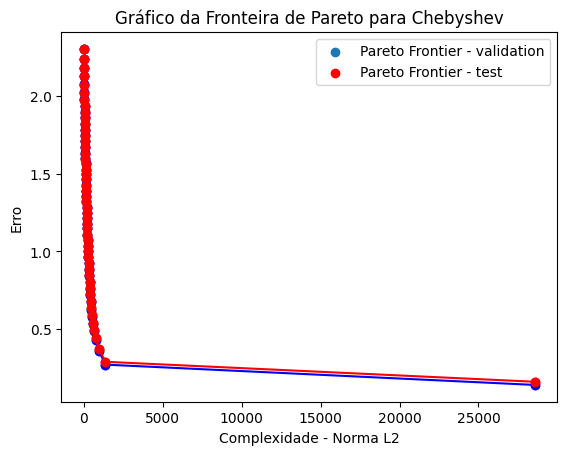

In [ ]:
# Ordena os pontos da fronteira de Pareto com base na norma L2
pareto_metrics_cheb_sorted = sorted(pareto_metrics_cheb, key=lambda x: x[1])

# Extrai os erros e as normas ordenadas
norms_sorted, errors_sorted = zip(*pareto_metrics_cheb_sorted)

# Cria um gráfico de dispersão
plt.scatter(norms_sorted, errors_sorted, label='Pareto Frontier - validation')

# Adiciona uma linha ligando os pontos ordenados
plt.plot(norms_sorted, errors_sorted, linestyle='-', marker='o', color='b')

# Ordena os pontos da segunda linha com base na norma L2
pareto_metrics_second_line_sorted = sorted(pareto_metrics_cheb_test, key=lambda x: x[1])

# Extrai os erros e as normas ordenadas da segunda linha
norms_second_line_sorted, errors_second_line_sorted = zip(*pareto_metrics_second_line_sorted)

# Cria um gráfico de dispersão para a segunda linha
plt.scatter(norms_second_line_sorted, errors_second_line_sorted, label='Pareto Frontier - test', color='red')

# Adiciona uma linha ligando os pontos ordenados da segunda linha
plt.plot(norms_second_line_sorted, errors_second_line_sorted, linestyle='-', marker='o', color='red')

# Adiciona rótulos aos eixos
plt.xlabel('Complexidade - Norma L2')
plt.ylabel('Erro')

# Adiciona um título ao gráfico
plt.title('Gráfico da Fronteira de Pareto para Chebyshev')

# Adiciona uma legenda ao gráfico
plt.legend()

# Exibe o gráfico
plt.show()

In [ ]:
# Dados de treino
for i, (epochs, train_loss) in enumerate(epochs_loss_train_cheb, start=1):
    print(f"Rede Neural {i} - Dados de Treino:")
    for epoch, loss in zip(epochs, train_loss):
        print(f"Época {epoch}: Loss = {loss}")
    print("\n")

# Dados de validação
for i, (epochs, val_loss) in enumerate(epochs_loss_val_cheb, start=1):
    print(f"Rede Neural {i} - Dados de Validação:")
    for epoch, loss in zip(epochs, val_loss):
        print(f"Época {epoch}: Loss = {loss}")
    print("\n")

Rede Neural 1 - Dados de Treino:
Época 1: Loss = 0.7611212730407715
Época 2: Loss = 0.7397918701171875
Época 3: Loss = 0.7369136810302734
Época 4: Loss = 0.7357702255249023
Época 5: Loss = 0.7349607348442078
Época 6: Loss = 0.7346922159194946
Época 7: Loss = 0.7338745594024658
Época 8: Loss = 0.7335906028747559
Época 9: Loss = 0.7341543436050415
Época 10: Loss = 0.7340173721313477


Rede Neural 2 - Dados de Treino:
Época 1: Loss = 0.316381573677063
Época 2: Loss = 0.3056592345237732
Época 3: Loss = 0.30597418546676636
Época 4: Loss = 0.3058643341064453
Época 5: Loss = 0.30588942766189575
Época 6: Loss = 0.30587759613990784
Época 7: Loss = 0.3058149218559265
Época 8: Loss = 0.3058815002441406
Época 9: Loss = 0.305888295173645
Época 10: Loss = 0.30591100454330444


Rede Neural 3 - Dados de Treino:
Época 1: Loss = 0.750291109085083
Época 2: Loss = 0.7288339734077454
Época 3: Loss = 0.7254956960678101
Época 4: Loss = 0.724349856376648
Época 5: Loss = 0.7240132689476013
Época 6: Loss = 0.72

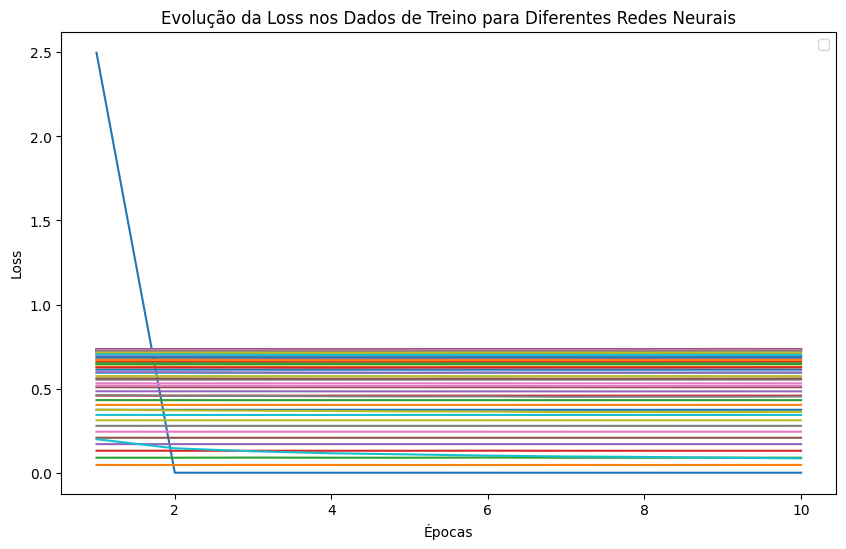

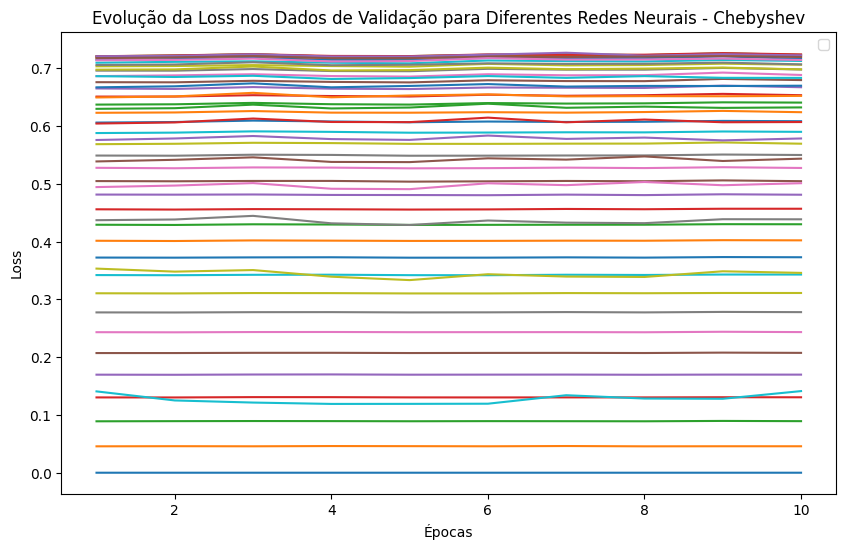

In [ ]:
# Crie um gráfico para os dados de treino
plt.figure(figsize=(10, 6))

for i, (epochs, train_loss) in enumerate(epochs_loss_train_cheb, start=1):
    # Adicione uma linha para cada rede neural
    plt.plot(epochs, train_loss)

# Adicione rótulos aos eixos
plt.xlabel('Épocas')
plt.ylabel('Loss')

# Adicione um título ao gráfico
plt.title('Evolução da Loss nos Dados de Treino para Diferentes Redes Neurais')

# Adicione uma legenda ao gráfico
plt.legend()

# Exiba o gráfico
plt.show()

# Crie um gráfico para os dados de validação
plt.figure(figsize=(10, 6))

for i, (epochs, val_loss) in enumerate(epochs_loss_val_cheb, start=1):
    # Adicione uma linha para cada rede neural
    plt.plot(epochs, val_loss)

# Adicione rótulos aos eixos
plt.xlabel('Épocas')
plt.ylabel('Loss')

# Adicione um título ao gráfico
plt.title('Evolução da Loss nos Dados de Validação para Diferentes Redes Neurais - Chebyshev')

# Adicione uma legenda ao gráfico
plt.legend()

# Exiba o gráfico
plt.show()


In [ ]:
pareto_metrics_cheb_tests_3D_nor = []
complexidade_mínimo = 1e12
complexidade_máximo = 0
erro_mínimo = 1e12
erro_máximo = 0

# Imprima os dados
for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_cheb_tests_3D, start=1):
    print(f'Rede Neuronal {i}: Complexidade={complexidade}, Erro={erro}, Loss={loss}, wheight1={wheight1}, wheight2={wheight2}')
    complexidade_mínimo = min(complexidade_mínimo, complexidade)
    complexidade_máximo = max(complexidade_máximo, complexidade)
    erro_mínimo = min(erro_mínimo, erro)
    erro_máximo = max(erro_máximo, erro)

for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_cheb_tests_3D, start=1):
    erro_nor =  (erro - erro_mínimo) / (erro_máximo - erro_mínimo)
    complexidade_nor = (complexidade - complexidade_mínimo) / (complexidade_máximo - complexidade_mínimo)
    loss_nor = erro_nor * wheight1 + complexidade_nor * wheight2
    pareto_metrics_cheb_tests_3D_nor.append((complexidade_nor, erro_nor, loss_nor, wheight1, wheight2))

print()
print("Dados Normalizados:")
for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_cheb_tests_3D_nor, start=1):
    print(f'Rede Neuronal {i}: Complexidade={complexidade}, Erro={erro}, Loss={loss}, wheight1={wheight1}, wheight2={wheight2}')

Rede Neuronal 1: Complexidade=8.469532622257248e-05, Erro=2.3025825023651123, Loss=5.394607001107943e-07, wheight1=0.0, wheight2=1.0
Rede Neuronal 2: Complexidade=7.086946487426758, Erro=2.2377305030822754, Loss=0.04576810821890831, wheight1=0.02040816326530612, wheight2=0.9795918367346939
Rede Neuronal 3: Complexidade=13.994668006896973, Erro=2.1777305603027344, Loss=0.08922085911035538, wheight1=0.04081632653061224, wheight2=0.9591836734693877
Rede Neuronal 4: Complexidade=20.464340209960938, Erro=2.1273622512817383, Loss=0.13047608733177185, wheight1=0.061224489795918366, wheight2=0.9387755102040817
Rede Neuronal 5: Complexidade=27.066144943237305, Erro=2.072580337524414, Loss=0.16959746181964874, wheight1=0.08163265306122448, wheight2=0.9183673469387755
Rede Neuronal 6: Complexidade=33.70469665527344, Erro=2.0215487480163574, Loss=0.2071704864501953, wheight1=0.1020408163265306, wheight2=0.8979591836734694
Rede Neuronal 7: Complexidade=40.06326675415039, Erro=1.976430058479309, Los

<ipython-input-24-43415af8cabf>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[i], y[i], z[i], c=color, marker=marker, label=label)


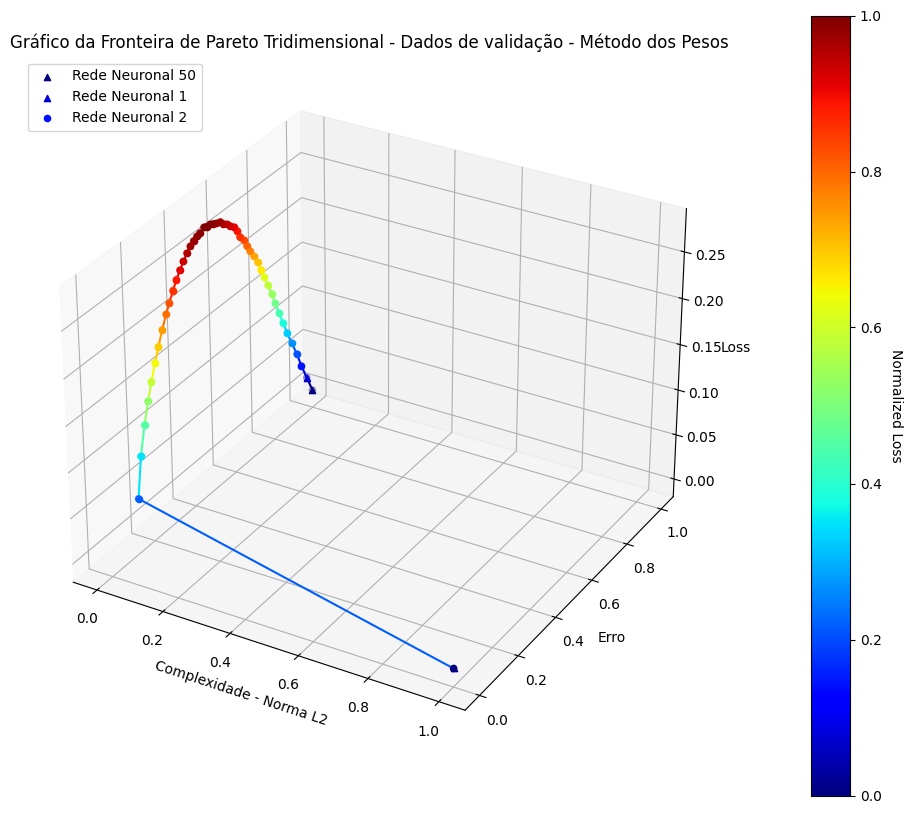

In [ ]:
# Extraia as variáveis
x, y, z, w1, w2 = zip(*pareto_metrics_cheb_tests_3D_nor)

# Crie a figura e o eixo 3D com tamanho ajustado
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Converta z para um array NumPy e normalize os valores para obter cores entre 0 e 1
normalized_z = (np.array(z) - min(z)) / (max(z) - min(z))

# Encontre os índices dos 3 pontos com menor valor de z
indice_3_menores_z = np.argpartition(z, 3)[:3]

for i in range(len(x)):
    marker = 'o' if not np.any(i == indice_3_menores_z) else '^'
    color = plt.cm.jet(normalized_z[i])
    label = None if not np.any(i == indice_3_menores_z) else f'Rede Neuronal {i + 1}'

    # Plote os pontos individuais
    ax.scatter(x[i], y[i], z[i], c=color, marker=marker, label=label)

# Plote a linha conectando os pontos e variação de cor
for i in range(len(x) - 1):
    color = plt.cm.jet(normalized_z[i])
    ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], [z[i], z[i + 1]], color=color)

# Adicione a barra de cores
cbar = fig.colorbar(ax.scatter(x, y, z, c=normalized_z, cmap='jet', marker='o'), ax=ax, pad=0.1)
cbar.set_label('Normalized Loss', rotation=270, labelpad=15)

# Rotule os eixos
ax.set_xlabel('Complexidade - Norma L2')
ax.set_ylabel('Erro')
ax.set_zlabel('Loss')

# Ajuste a posição da legenda e aumente o espaço entre os subplots
fig.subplots_adjust(bottom=0.1)

# Adicione um título ao gráfico
ax.set_title('Gráfico da Fronteira de Pareto Tridimensional - Dados de validação - Método dos Pesos')

# Adicione a legenda
ax.legend([f'Rede Neuronal {i + 1}' for i in indice_3_menores_z], loc='upper left')

# Mostre o gráfico
plt.show()

In [ ]:
pareto_metrics_cheb_3D_nor = []
complexidade_mínimo = 1e12
complexidade_máximo = 0
erro_mínimo = 1e12
erro_máximo = 0

# Imprima os dados
for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_cheb_3D, start=1):
    print(f'Rede Neuronal {i}: Complexidade={complexidade}, Erro={erro}, Loss={loss}, wheight1={wheight1}, wheight2={wheight2}')
    complexidade_mínimo = min(complexidade_mínimo, complexidade)
    complexidade_máximo = max(complexidade_máximo, complexidade)
    erro_mínimo = min(erro_mínimo, erro)
    erro_máximo = max(erro_máximo, erro)

for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_cheb_3D, start=1):
    erro_nor =  (erro - erro_mínimo) / (erro_máximo - erro_mínimo)
    complexidade_nor = (complexidade - complexidade_mínimo) / (complexidade_máximo - complexidade_mínimo)
    loss_nor = erro_nor * wheight1 + complexidade_nor * wheight2
    pareto_metrics_cheb_3D_nor.append((complexidade_nor, erro_nor, loss_nor, wheight1, wheight2))

print()
print("Dados Normalizados:")
for i, (complexidade, erro, loss, wheight1, wheight2) in enumerate(pareto_metrics_cheb_3D_nor, start=1):
    print(f'Rede Neuronal {i}: Complexidade={complexidade}, Erro={erro}, Loss={loss}, wheight1={wheight1}, wheight2={wheight2}')

Rede Neuronal 1: Complexidade=8.469532622257248e-05, Erro=2.3025825023651123, Loss=5.394607001107943e-07, wheight1=0.0, wheight2=1.0
Rede Neuronal 2: Complexidade=7.086946487426758, Erro=2.2383933067321777, Loss=0.04577729105949402, wheight1=0.02040816326530612, wheight2=0.9795918367346939
Rede Neuronal 3: Complexidade=13.994668006896973, Erro=2.1780905723571777, Loss=0.08922822028398514, wheight1=0.04081632653061224, wheight2=0.9591836734693877
Rede Neuronal 4: Complexidade=20.464340209960938, Erro=2.1286513805389404, Loss=0.13054713606834412, wheight1=0.061224489795918366, wheight2=0.9387755102040817
Rede Neuronal 5: Complexidade=27.066144943237305, Erro=2.0744268894195557, Loss=0.169736847281456, wheight1=0.08163265306122448, wheight2=0.9183673469387755
Rede Neuronal 6: Complexidade=33.70469665527344, Erro=2.0240132808685303, Loss=0.207387775182724, wheight1=0.1020408163265306, wheight2=0.8979591836734694
Rede Neuronal 7: Complexidade=40.06326675415039, Erro=1.979407787322998, Loss=

<ipython-input-26-a6195a2ccb0c>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[i], y[i], z[i], c=color, marker=marker, label=label)


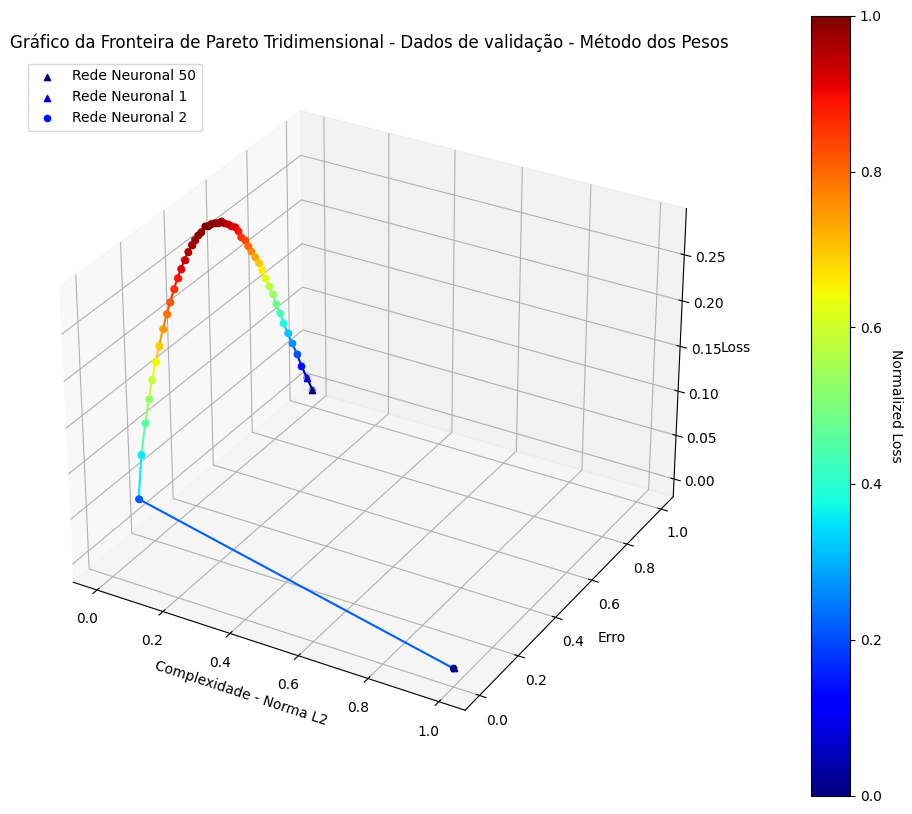

In [ ]:
# Extraia as variáveis
x, y, z, w1, w2 = zip(*pareto_metrics_cheb_3D_nor)

# Crie a figura e o eixo 3D com tamanho ajustado
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Converta z para um array NumPy e normalize os valores para obter cores entre 0 e 1
normalized_z = (np.array(z) - min(z)) / (max(z) - min(z))

# Encontre os índices dos 3 pontos com menor valor de z
indice_3_menores_z = np.argpartition(z, 3)[:3]

for i in range(len(x)):
    marker = 'o' if not np.any(i == indice_3_menores_z) else '^'
    color = plt.cm.jet(normalized_z[i])
    label = None if not np.any(i == indice_3_menores_z) else f'Rede Neuronal {i + 1}'

    # Plote os pontos individuais
    ax.scatter(x[i], y[i], z[i], c=color, marker=marker, label=label)

# Plote a linha conectando os pontos e variação de cor
for i in range(len(x) - 1):
    color = plt.cm.jet(normalized_z[i])
    ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], [z[i], z[i + 1]], color=color)

# Adicione a barra de cores
cbar = fig.colorbar(ax.scatter(x, y, z, c=normalized_z, cmap='jet', marker='o'), ax=ax, pad=0.1)
cbar.set_label('Normalized Loss', rotation=270, labelpad=15)

# Rotule os eixos
ax.set_xlabel('Complexidade - Norma L2')
ax.set_ylabel('Erro')
ax.set_zlabel('Loss')

# Ajuste a posição da legenda e aumente o espaço entre os subplots
fig.subplots_adjust(bottom=0.1)

# Adicione um título ao gráfico
ax.set_title('Gráfico da Fronteira de Pareto Tridimensional - Dados de validação - Método dos Pesos')

# Adicione a legenda
ax.legend([f'Rede Neuronal {i + 1}' for i in indice_3_menores_z], loc='upper left')

# Mostre o gráfico
plt.show()

In [ ]:
class Lexicographic:
    def __init__(self, error_weight=0.9, complexity_weight=0.1, tolerance=1e-6):
        self.error_weight = error_weight
        self.complexity_weight = complexity_weight
        self.tolerance = tolerance

    def optimize(self, model, x_train, y_train, x_val, y_val, epochs=5):
        opt = tf.keras.optimizers.Adam()  # Use any optimizer of your choice
        best_loss = float('inf')

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")

            # Train the model
            model.compile(optimizer=opt, loss=self.custom_loss, metrics=['categorical_crossentropy', self.l2_metric])
            model.fit(x_train, y_train, epochs=1, validation_data=(x_val, y_val))

            # Evaluate the model on the validation set
            metrics = model.evaluate(x_val, y_val)
            current_loss = metrics[0]

            # Check if the current loss is within the tolerance level
            if best_loss - current_loss > self.tolerance:
                best_loss = current_loss
                print(f"Updated best loss: {best_loss}")
            else:
                print(f"Tolerance reached. Stopping optimization.")
                break

    def custom_loss(self, y_true, y_pred):
        cross_entropy_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in model.trainable_weights])

        return self.error_weight * cross_entropy_loss + self.complexity_weight * l2_loss

    def l2_metric(self, y_true, y_pred):
        return tf.add_n([tf.nn.l2_loss(weight) for weight in model.trainable_weights])

In [ ]:
# Create Lexicographic optimizer
lex_optimizer = Lexicographic(error_weight=0.9, complexity_weight=0.1, tolerance=1e-6)
# Optimize the model
lex_optimizer.optimize(model, train_images, train_labels, validation_images, validation_labels, epochs=10)

Epoch 1/10
157/157 [==============================] - 0s 2ms/step - loss: 0.8453 - categorical_crossentropy: 0.4889 - l2_metric: 4.0526
Updated best loss: 0.8453119397163391
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 0.8357 - categorical_crossentropy: 0.4793 - l2_metric: 4.0431
Updated best loss: 0.835713267326355
Epoch 3/10
1604/1875 [========================>.....] - ETA: 1s - loss: 0.8595 - categorical_crossentropy: 0.5016 - l2_metric: 4.0807

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-fbcfae97cef6>", line 4, in <cell line: 4>
    lex_optimizer.optimize(model, train_images, train_labels, validation_images, validation_labels, epochs=10)
  File "<ipython-input-4-1ac11c5b2d06>", line 16, in optimize
    model.fit(x_train, y_train, epochs=1, validation_data=(x_val, y_val))
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflo

TypeError: object of type 'NoneType' has no len()

In [ ]:
N_tolerances = 10

for i in range(N_tolerances):

  tolerance = np.linspace(0, 1, N_tolerances, endpoint=True)[i]
  print(tolerance)

  # Create Lexicographic optimizer
  lex_optimizer = Lexicographic(error_weight=0.9, complexity_weight=0.1, tolerance=tolerance)
  # Optimize the model
  lex_optimizer.optimize(model, train_images, train_labels, validation_images, validation_labels, epochs=10)

0.0
Epoch 1/10
157/157 [==============================] - 0s 1ms/step - loss: 0.8126 - categorical_crossentropy: 0.4590 - l2_metric: 3.9952
Updated best loss: 0.8126125335693359
Epoch 2/10
157/157 [==============================] - 0s 1ms/step - loss: 0.8126 - categorical_crossentropy: 0.4577 - l2_metric: 4.0072
Tolerance reached. Stopping optimization.
0.1111111111111111
Epoch 1/10
157/157 [==============================] - 0s 1ms/step - loss: 0.8124 - categorical_crossentropy: 0.4588 - l2_metric: 3.9948
Updated best loss: 0.8124326467514038
Epoch 2/10
157/157 [==============================] - 0s 1ms/step - loss: 0.8128 - categorical_crossentropy: 0.4588 - l2_metric: 3.9988
Tolerance reached. Stopping optimization.
0.2222222222222222
Epoch 1/10
157/157 [==============================] - 0s 1ms/step - loss: 0.8125 - categorical_crossentropy: 0.4591 - l2_metric: 3.9927
Updated best loss: 0.8124939203262329
Epoch 2/10
157/157 [==============================] - 0s 1ms/step - loss: 0.8128

Training model with tolerance=1e-06
Epoch 1/5
157/157 [==============================] - 0s 2ms/step - loss: 0.8454 - categorical_crossentropy: 0.4886 - l2_metric: 4.0568
Updated best loss: 0.8453845977783203
Epoch 2/5
157/157 [==============================] - 0s 2ms/step - loss: 0.8357 - categorical_crossentropy: 0.4786 - l2_metric: 4.0496
Updated best loss: 0.835712194442749
Epoch 3/5
157/157 [==============================] - 0s 2ms/step - loss: 0.8313 - categorical_crossentropy: 0.4748 - l2_metric: 4.0398
Updated best loss: 0.8312729597091675
Epoch 4/5
157/157 [==============================] - 0s 2ms/step - loss: 0.8260 - categorical_crossentropy: 0.4700 - l2_metric: 4.0303
Updated best loss: 0.8260317444801331
Epoch 5/5
157/157 [==============================] - 0s 2ms/step - loss: 0.8231 - categorical_crossentropy: 0.4679 - l2_metric: 4.0204
Updated best loss: 0.8231227397918701
157/157 [==============================] - 0s 2ms/step - loss: 0.8323 - categorical_crossentropy: 0.

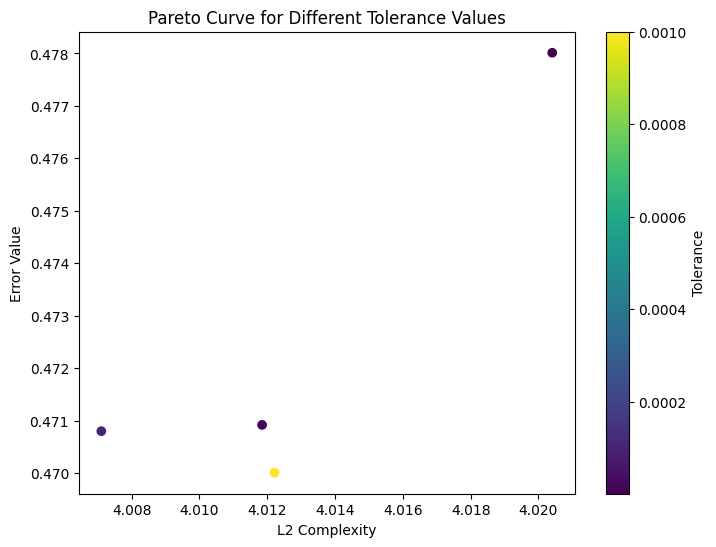

In [ ]:
# Define a range of tolerance values
tolerance_values = [1e-6, 1e-5, 1e-4, 1e-3]

# Initialize lists to store metrics for each tolerance value
pareto_metrics_wheights_list = []

for tolerance in tolerance_values:
    print(f"Training model with tolerance={tolerance}")

    lex_optimizer = Lexicographic(tolerance=tolerance)

    # Train the model using Lexicographic optimization
    lex_optimizer.optimize(model, train_images, train_labels, validation_images, validation_labels, epochs=5)

    # Evaluate the model and collect metrics
    metrics = model.evaluate(test_images, test_labels)
    error_value = metrics[1]
    l2_complexity = metrics[2]

    pareto_metrics_wheights_list.append((l2_complexity, error_value))

# Convert the list to a NumPy array for easier manipulation
pareto_metrics_wheights_array = np.array(pareto_metrics_wheights_list)

# Plot the Pareto curve
plt.figure(figsize=(8, 6))
plt.scatter(pareto_metrics_wheights_array[:, 0], pareto_metrics_wheights_array[:, 1], c=tolerance_values, cmap='viridis')
plt.xlabel('L2 Complexity')
plt.ylabel('Error Value')
plt.title('Pareto Curve for Different Tolerance Values')
plt.colorbar(label='Tolerance')
plt.show()

In [ ]:
import time

# Initialize lists to store the smallest errors for each tolerance value
smallest_errors_train = []
smallest_errors_validation = []
smallest_errors_test = []

# Initialize lists to store training times for each tolerance value
training_times = []

# Define the number of intervals for each linspace
num_intervals = 10

# Initialize an empty list to store tolerance values
tolerance_values = []

# Define the start and end points for each linspace
linspace_ranges = [(1e-8, 1e-7), (1e-7, 1e-6), (1e-6, 1e-5), (1e-5, 1e-4), (1e-4, 1e-3), (1e-3, 1e-2), (1e-2, 1e-1)]

# Generate tolerance values using a nested for loop
for start, end in linspace_ranges:
    interval_values = np.linspace(start, end, num_intervals, endpoint=False)
    tolerance_values.extend(interval_values)

# Convert the list to a NumPy array if needed
tolerance_values = np.array(tolerance_values)

# Initialize lists to store metrics for each tolerance value
pareto_metrics_wheights_list = []

for tolerance in tolerance_values:
    print(f"Training model with tolerance={tolerance}")

    # Start the timer
    start_time = time.time()

    # Create and compile the model
    model  # Replace with your model creation function
    lex_optimizer = Lexicographic(tolerance=tolerance)

    # Train the model using Lexicographic optimization
    lex_optimizer.optimize(model, train_images, train_labels, validation_images, validation_labels, epochs=20)

    # End the timer
    end_time = time.time()

    # Calculate the training time and store it
    training_time = end_time - start_time
    training_times.append(training_time)

    # Evaluate the model on the training dataset
    error_values_train = model.evaluate(train_images, train_labels)[1]
    # Find the smallest error for this tolerance value on the training dataset
    smallest_errors_train.append(error_values_train)

    # Evaluate the model on the validation dataset
    error_values_validation = model.evaluate(validation_images, validation_labels)[1]
    # Find the smallest error for this tolerance value on the validation dataset
    smallest_errors_validation.append(error_values_validation)

    # Evaluate the model on the test dataset
    error_values_test = model.evaluate(test_images, test_labels)[1]
    # Find the smallest error for this tolerance value on the test dataset
    smallest_errors_test.append(error_values_test)

Training model with tolerance=1e-08
Epoch 1/20
157/157 [==============================] - 0s 1ms/step - loss: 0.8391 - categorical_crossentropy: 0.4821 - l2_metric: 4.0524
Updated best loss: 0.8391023278236389
Epoch 2/20
157/157 [==============================] - 0s 1ms/step - loss: 0.8277 - categorical_crossentropy: 0.4703 - l2_metric: 4.0444
Updated best loss: 0.8276823163032532
Epoch 3/20
157/157 [==============================] - 0s 1ms/step - loss: 0.8247 - categorical_crossentropy: 0.4667 - l2_metric: 4.0471
Updated best loss: 0.8247467875480652
Epoch 4/20
157/157 [==============================] - 0s 1ms/step - loss: 0.8224 - categorical_crossentropy: 0.4660 - l2_metric: 4.0300
Updated best loss: 0.8224331736564636
Epoch 5/20
157/157 [==============================] - 0s 1ms/step - loss: 0.8214 - categorical_crossentropy: 0.4656 - l2_metric: 4.0234
Updated best loss: 0.8213904500007629
Epoch 6/20
157/157 [==============================] - 0s 1ms/step - loss: 0.8205 - categorical

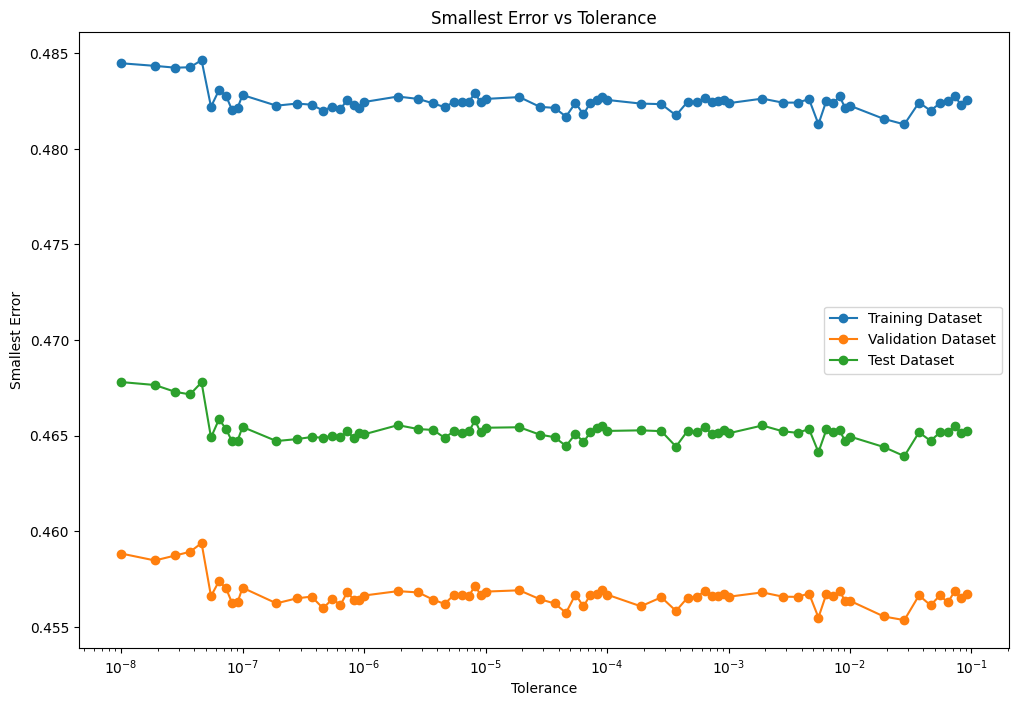

In [ ]:
# Convert the lists to NumPy arrays for easier manipulation
smallest_errors_train_array = np.array(smallest_errors_train)
smallest_errors_validation_array = np.array(smallest_errors_validation)
smallest_errors_test_array = np.array(smallest_errors_test)

# Plot the 2D graphs for each dataset
plt.figure(figsize=(12, 8))

plt.plot(tolerance_values, smallest_errors_train_array, marker='o', label='Training Dataset')
plt.plot(tolerance_values, smallest_errors_validation_array, marker='o', label='Validation Dataset')
plt.plot(tolerance_values, smallest_errors_test_array, marker='o', label='Test Dataset')

plt.xlabel('Tolerance')
plt.ylabel('Smallest Error')
plt.title('Smallest Error vs Tolerance')
plt.xscale('log')  # Use a logarithmic scale for better visualization if the tolerance values vary widely
plt.legend()
plt.show()

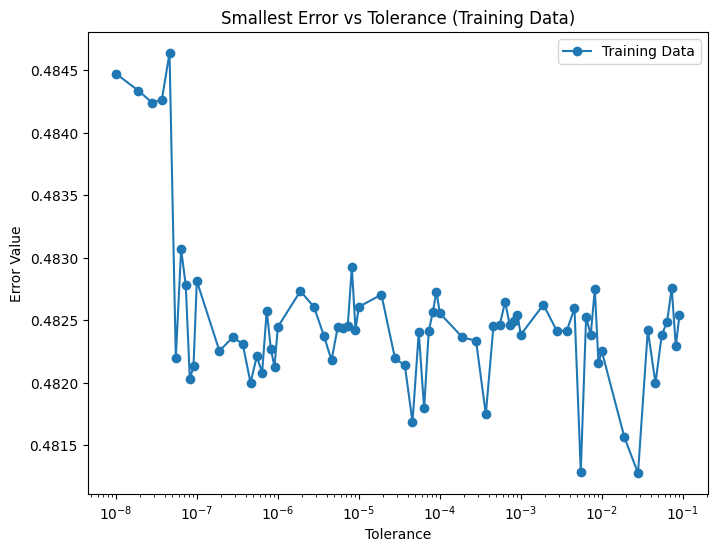

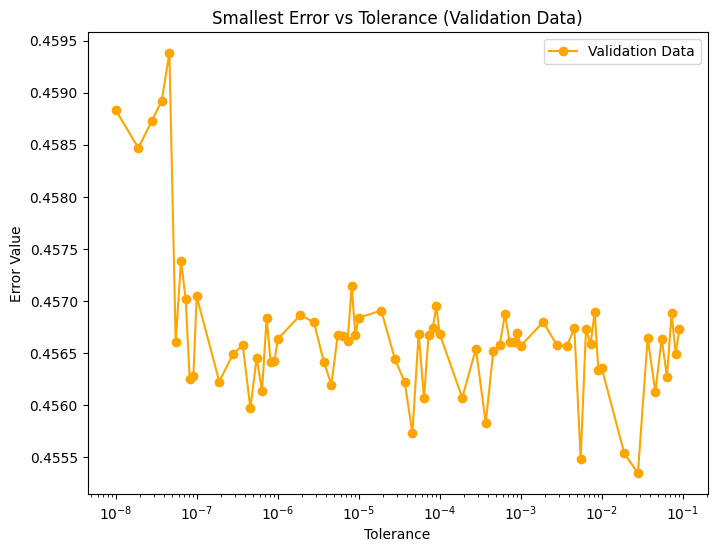

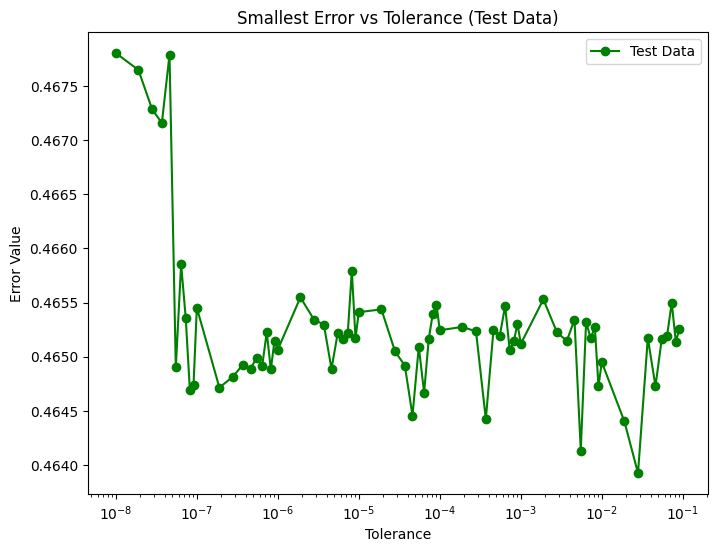

In [ ]:
# Plot the error values for the training dataset
plt.figure(figsize=(8, 6))
plt.plot(tolerance_values, smallest_errors_train, marker='o', label='Training Data')
plt.xlabel('Tolerance')
plt.ylabel('Error Value')
plt.title('Smallest Error vs Tolerance (Training Data)')
plt.xscale('log')  # Use a logarithmic scale for better visualization if the tolerance values vary widely
plt.legend()
plt.show()

# Plot the error values for the validation dataset
plt.figure(figsize=(8, 6))
plt.plot(tolerance_values, smallest_errors_validation, marker='o', color='orange', label='Validation Data')
plt.xlabel('Tolerance')
plt.ylabel('Error Value')
plt.title('Smallest Error vs Tolerance (Validation Data)')
plt.xscale('log')  # Use a logarithmic scale for better visualization if the tolerance values vary widely
plt.legend()
plt.show()

# Plot the error values for the test dataset
plt.figure(figsize=(8, 6))
plt.plot(tolerance_values, smallest_errors_test, marker='o', color='green', label='Test Data')
plt.xlabel('Tolerance')
plt.ylabel('Error Value')
plt.title('Smallest Error vs Tolerance (Test Data)')
plt.xscale('log')  # Use a logarithmic scale for better visualization if the tolerance values vary widely
plt.legend()
plt.show()

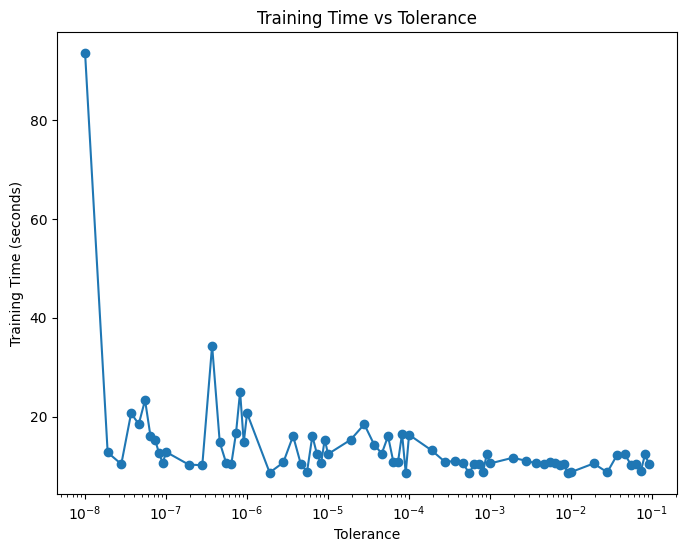

In [ ]:
# Convert the list to a NumPy array for easier manipulation
training_times_array = np.array(training_times)

# Plot the 2D graph
plt.figure(figsize=(8, 6))
plt.plot(tolerance_values, training_times_array, marker='o')
plt.xlabel('Tolerance')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs Tolerance')
plt.xscale('log')  # Use a logarithmic scale for better visualization if the tolerance values vary widely
plt.show()